# Neural Network classification with PyTorch

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:, 0],
                        "X2":X[:, 1],
                        "label":y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


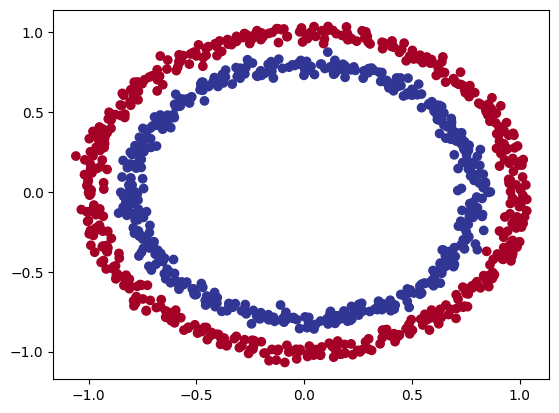

In [5]:
# Visualiza
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
y_sample = y[0]
X_sample, y_sample, X_sample.shape, y_sample.shape

(array([0.75424625, 0.23148074]), 1, (2,), ())

### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch
from sklearn.model_selection import train_test_split

In [9]:
# Turn data into tensors
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

X_tensor[:5], y_tensor[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model


In [12]:
import torch
from torch import nn

In [13]:
# 1. setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
# 2. Construct a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(in_features=2, out_features=5)
    self.fc2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [15]:
# instantiate andd instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [17]:
# using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6970,  0.2040],
                      [-0.6836,  0.6352],
                      [-0.1083,  0.4687],
                      [ 0.4215,  0.3415],
                      [-0.2491, -0.5503]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4331, -0.5946,  0.4003, -0.5574,  0.2975], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0701,  0.1803, -0.0994, -0.1564,  0.0590]], device='cuda:0')),
             ('1.bias', tensor([0.3570], device='cuda:0'))])

In [19]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds.shape, len(untrained_preds), torch.round(untrained_preds[:5])

(torch.Size([200, 1]),
 200,
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'))

In [20]:
X_test.shape, untrained_preds.shape

(torch.Size([200, 2]), torch.Size([200, 1]))

## 2.1 Setup loss function and optimizer

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

In [22]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

In [23]:
torch.manual_seed(42)

epochs = 100
losses = []
val_losses = []
accuracy = []
val_accuracy = []

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                 y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():

    y_logits = model_0(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    val_loss = loss_fn(y_logits, y_test)
    val_acc = accuracy_fn(y_true=y_test,
                       y_pred=y_pred)

  losses.append(loss)
  val_losses.append(val_loss)
  accuracy.append(acc)
  val_accuracy.append(val_acc)

  if epoch % 10 == 0:
    print(f'epoch:{epoch} | loss:{loss:.5f}, acc:{acc:.2f} | val_loss:{val_loss:.5f}, val_acc:{val_acc:.2f}')

epoch:0 | loss:0.70678, acc:50.00 | val_loss:0.70246, val_acc:50.00
epoch:10 | loss:0.69983, acc:55.62 | val_loss:0.69720, val_acc:54.00
epoch:20 | loss:0.69712, acc:50.75 | val_loss:0.69533, val_acc:55.50
epoch:30 | loss:0.69585, acc:50.00 | val_loss:0.69455, val_acc:56.50
epoch:40 | loss:0.69512, acc:49.75 | val_loss:0.69416, val_acc:56.00
epoch:50 | loss:0.69463, acc:49.88 | val_loss:0.69393, val_acc:55.50
epoch:60 | loss:0.69427, acc:50.12 | val_loss:0.69378, val_acc:53.50
epoch:70 | loss:0.69400, acc:49.75 | val_loss:0.69369, val_acc:53.50
epoch:80 | loss:0.69379, acc:49.88 | val_loss:0.69363, val_acc:54.00
epoch:90 | loss:0.69362, acc:49.25 | val_loss:0.69361, val_acc:55.50


 ## 4. Make predictions

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

--2024-05-18 12:05:21--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2024-05-18 12:05:22 (101 MB/s) - ‘helper_functions.py’ saved [10160/10160]



In [25]:
from helper_functions import plot_decision_boundary, plot_predictions

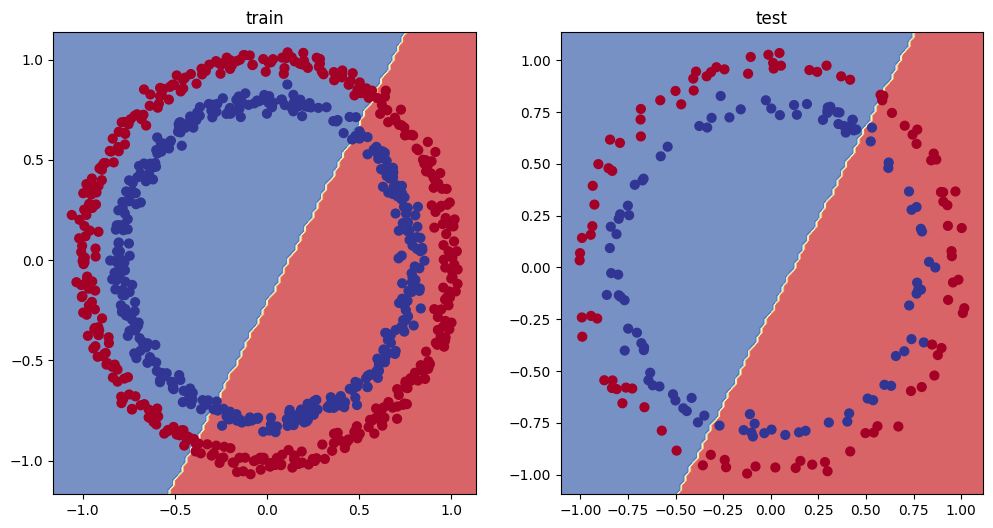

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a modddel perspective)

In [29]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=128)
    self.layer_2 = nn.Linear(in_features=128, out_features=256)
    self.layer_3 = nn.Linear(in_features=256, out_features=1)

  def forward(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.layer_3(x)

In [31]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=1, bias=True)
)